In [0]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = '/content/drive/My Drive/UrbanSound8K/audio/fold1/101415-3-0-2.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate)

Original sample rate: 48000
Librosa sample rate: 22050


In [0]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -27967 to 26427
Librosa audio file min~max range: -0.8541817 to 0.8053372


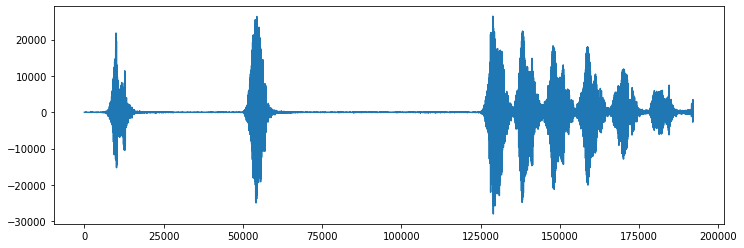

In [0]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

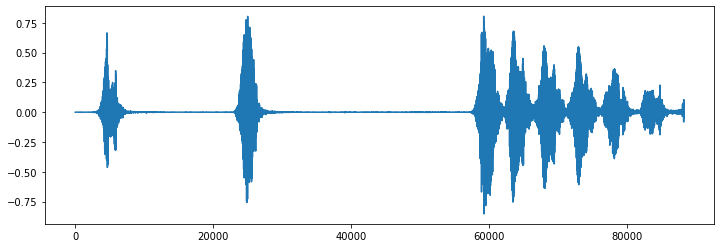

In [0]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

In [0]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


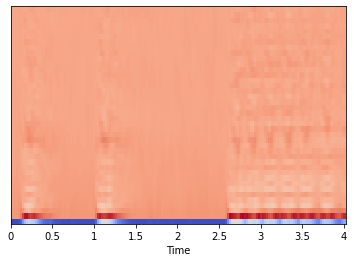

In [0]:
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

Mel-frequency cepstral coefficients (MFCC) for each audio file in the dataset will be extracted and store it in a Panda Dataframe along with it's classification label. CNNs require a fixed size for all inputs. Hence, output vectors are zero pad to make all of them of th same size.

In [0]:
import numpy as np
max_pad_len = 174

def extract_features(file_name):
    i=0
  
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
       
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [0]:
import pandas as pd
import os
import librosa

 
fulldatasetpath = '/content/drive/My Drive/UrbanSound8K/audio/'
metadata = pd.read_csv('/content/UrbanSound8K.csv')

features = []
 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["types"]
    data = extract_features(file_name)
    
    features.append([data, class_label])
   
 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  8732  files


Sklearn.preprocessing.LabelEncoder is used to encode the categorical text data into model-understandable numerical data. We have used sklearn.model_selection.train_test_split to split the dataset into training and testing sets. The testing set size will be 20% and we will set a random state.

In [0]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

Using TensorFlow backend.


Convolutional Neural Network model is designed using Keras and Tensorflow backend. Our model consists of 5 Conv2d convolutional layers with final output layer is dense layer, for this we have used a sequential model. Convolution layers are used for feature detection, by sliding a filter window over the input and performing a matrix multiplication and storing the result in a feature map. The filter parameter specifies the number of nodes in each layer. Each layer will be increase size from 16, 32, 64, 128 to 256 while the kernel size paramater specifies the size of kernel window which in this case is 2 resulting a 2x2 filter matrix.

The first layer will receive the input shape of (40,174,1) where 40 is the number of MFCC's 174 is the number of frames taking padding into account and the 1 signifying that the audio is mono. The activation function used for covolution layers is ReLU. We will use deoupout value of 20% on our convolution layers. 

Each convolution layer has an associated pooling layer of MaxPooling2D type with the final convolution layer having a global average pooling 2D type. 

The pooling layer is to reduce the dimensionality of the model which serves to shorten the training time and reduce overfitting. The Max Poolinh type takes the maximum size for each window and the Global Average Pooling type takes the average which is suitable for feeding out dense output layer.

Our output layer will have 10 nodes which matches the number of possible classifications. Activation for our output layer is softmax. Softmax akes the output sum up to 1 so the output can be interpreted as probablities. The model will then make this prediction based on which option has the highest probablity.

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

For compiling our model we will use three parameters 

In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Pre-Training

In [0]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 41, 64)        

Training

In [0]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_epochs = 92
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/UrbanSound8K/Saved_Model/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/92
6985/6985 [==============================] - 2s 224us/step - loss: 4.4871 - accuracy: 0.1989 - val_loss: 2.0501 - val_accuracy: 0.2702

Epoch 00001: val_loss improved from inf to 2.05012, saving model to /content/drive/My Drive/UrbanSound8K/Saved_Model/weights.best.basic_cnn.hdf5
Epoch 2/92
6985/6985 [==============================] - 1s 115us/step - loss: 1.9509 - accuracy: 0.3286 - val_loss: 1.8650 - val_accuracy: 0.3978

Epoch 00002: val_loss improved from 2.05012 to 1.86504, saving model to /content/drive/My Drive/UrbanSound8K/Saved_Model/weights.best.basic_cnn.hdf5
Epoch 3/92
6985/6985 [==============================] - 1s 115us/step - loss: 1.6322 - accuracy: 0.4190 - val_loss: 1.6253 - val_accuracy: 0.4865

Epoch 00003: val_loss improved from 1.86504 to 1.62528, saving model to /content/drive/My Drive/UrbanSound8K/Saved_Model/weights.best.basic_cnn.hdf5
Epoch 4/92
6985/6985 [==============================] - 1s 116us/ste

In [0]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9660701751708984
Testing Accuracy:  0.9112764596939087


In [0]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [0]:
filename = '/content/drive/My Drive/UrbanSound8K/audio/fold1/101415-3-0-2.wav' 
print_prediction(filename)

The predicted class is: dog_bark 

air_conditioner 		 :  0.00000000000000968568283844957467
car_horn 		 :  0.00000000000000004770163318902629
children_playing 		 :  0.00000008927701600214277277700603
dog_bark 		 :  0.99999988079071044921875000000000
drilling 		 :  0.00000000000001365397544512850572
engine_idling 		 :  0.00000000000000988745963901270508
gun_shot 		 :  0.00000000018504685284082000862327
jackhammer 		 :  0.00000000000000000000000025267257
siren 		 :  0.00000000000955539813940475823983
street_music 		 :  0.00000000013070232396383829609476
